In [90]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from numpy.linalg import inv,det


# Try just a gaussian beam

def Matmulvec(x2,y2,M,x1,y1):

    return (x2*M[0,0] + y2*M[1,0])*x1 + (x2*M[0,1] + y2*M[1,1])*y1

def GaussianPhase(x1,y1,Qinv,k):
    """Determine phase of a gaussian beam

    Parameters
    ----------
    x1 : numpy.ndarray
        detector coordinate in the x direction
    y1 : numpy.ndarray
        detector coordinate in the y direction
    Qinv : 2x2 numpy.ndarray
        inverse of the omplex curvature matrix
    k : scalar
        wavenumber = 2*pi/wavelength

    Returns
    -------
    numpy.ndarray
        phase of an astigmatic gaussian beam on a detector plane
    """
    
    return -1j*k/2 * Matmulvec(x1,y1,Qinv,x1,y1)

def ComputeGouyPhase(Q):

    eigvals = np.linalg.eigvals(Q)
    q1,q2 = eigvals[0],eigvals[1]

    gouy = .5*(np.arctan(np.real(q1)/np.imag(q1)) + np.arctan(np.real(q2)/np.imag(q2)))

    return gouy

def PropagateGaussianPhase(x1,y1,Qinv,k,sys):
    
    A = sys[0:2,0:2]
    B = sys[0:2,2:4]
    C = sys[2:4,0:2]
    D = sys[2:4,2:4]
    
    xd = 0
    yd = 0
    
    Q = inv(Qinv)
    Qpinv = (C + D @ Qinv) @ inv(A + B @ Qinv)
    Qp = inv(Qpinv)
    
    gaus = GaussianPhase(x,y,Qpinv,k)

    # Phase from decenter
    demat = np.linalg.inv(Q + np.linalg.inv(A) @ B)

    # Phase from cross term
    crmat = np.linalg.inv(A @ Q + B)

    # phase from decenter parameter
    gaus += -1j*k/2 * Matmulvec(xd,yd,demat,xd,yd) 
    
    # phase from coupling of decenter and position
    gaus += 1j*k * Matmulvec(xd,yd,crmat,x,y) 

    # apply gouy phase shift
    gaus += 1j*ComputeGouyPhase(Qp)

    # amplitude scaling
    amp = 1/np.sqrt((np.linalg.det(A + B @ Qinv)))
    
    return gaus,amp

def PropagateGaussian(x1,y1,Qinv,k,abcd):
    
    gaus,amp = PropagateGaussianPhase(x1,y1,Qinv,k,abcd)
    
    field = amp*np.exp(gaus)
    
    return field

def PropagateTruncatedGaussian(x1,y1,Qinv,k,sys,cx=0):
    
    from scipy.special import erfc
    
    A = sys[0:2,0:2]
    B = sys[0:2,2:4]
    C = sys[2:4,0:2]
    D = sys[2:4,2:4]
    
    Binv = inv(B)
    P = Qinv + Binv @ A
    
    npix = x1.shape[0]
    
    x1 = np.ravel(x1)
    y1 = np.ravel(y1)
    position = np.array([x1,y1])
    
    out = RotationMatrix(np.pi/4) @ position
    
    x1 = np.reshape(out[0,:],[npix,npix])
    y1 = np.reshape(out[1,:])
    
    field = PropagateGaussian(x1,y1,Qinv,k,abcd)
    
    # Grab from optical system
    gxx = -1j*k/2 * P[0,0]
    gyy = -1j*k/2 * P[1,1]
    gxy = -1j*k/2 * (P[0,1] + P[1,0])
    gx = 1j*k*(Binv[0,0]*x1 + Binv[0,1]*y1)
    gy = 1j*k*(Binv[1,0]*x1 + Binv[1,1]*y1)
    
    # Converting parameters
    h = gxy/(2*gyy)
    
    # Now do the truncation parameters
    ax = -(gxx - h**2 * gyy)
    bx = -(gx - h*gy)/2
    
    field *= 1/2 * erfc((bx + ax*cx)/np.sqrt(ax))
    
    return field


In [121]:
# set up optical system
wl = 1e-6
npix = 256

# set up detector
dsize = 4.95e-5*256 #1.22*wl*(57.6/2.4)*25
x = np.linspace(-dsize/2,dsize/2,npix)
x,y = np.meshgrid(x,x)

# set up gaussian
wo = 1000*wl
zr = np.pi * wo**2 / wl # meters
q  = 1j*zr
qinv = 1/q
k = 2*np.pi/wl


def RotationMatrix(th):
    return np.array([[np.cos(th),-np.sin(th)],
                     [np.sin(th),np.cos(th)]])

# an orthogonal beamlet
Qinv = np.array([[qinv,0],
                 [0,qinv]])

angle = np.pi/4
Qinv = Qinv
print(Qinv)



d = zr*0.0001
abcd = np.array([[1,0,d,0],
                 [0,1,0,d],
                 [0,0,1,0],
                 [0,0,0,1]])

field = PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx = 0)


[[0.-0.31830989j 0.+0.j        ]
 [0.+0.j         0.-0.31830989j]]


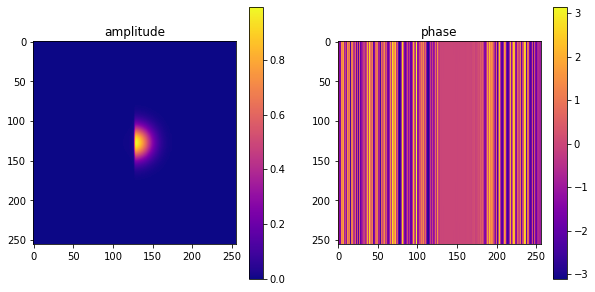

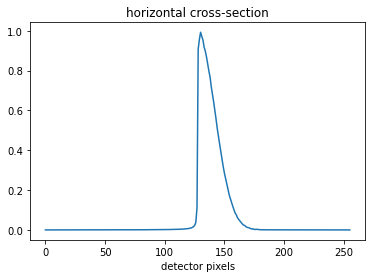

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(np.abs(field))
plt.title('amplitude')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(np.angle(field))
plt.title('phase')
plt.colorbar()
plt.show()

plt.figure()
plt.title('horizontal cross-section')
plt.plot(np.abs(field)[128,:])
plt.xlabel('detector pixels')
plt.show()

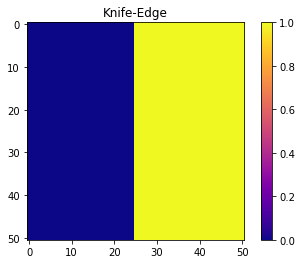

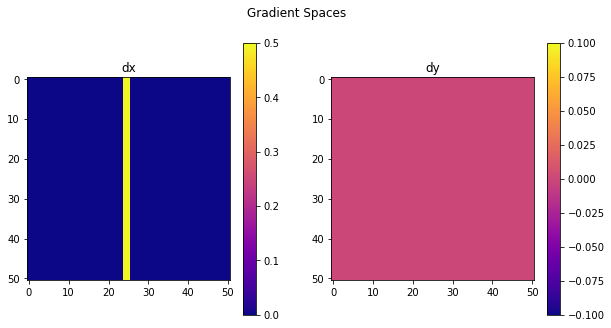

In [104]:
# Construct a Knife-Edge that's nbeamlets x nbeamlets
nrays = 51
aperture = np.zeros([nrays,nrays])
x = np.linspace(-1,1,nrays)
aperture[:,x >= 0] = 1

plt.figure()
plt.title('Knife-Edge')
plt.imshow(aperture)
plt.colorbar()
plt.show()

# Compute the Gradient of the Aperture
dy,dx = np.gradient(aperture)

plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(dx)
plt.title('dx')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(dy)
plt.title('dy')
plt.colorbar()
plt.show()
